In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import datetime as dt
import sqlalchemy

In [2]:
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

# Reflect Tables into SQLAlchemy ORM

In [3]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [4]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [5]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [6]:
# Create our session (link) from Python to the DB
session = Session(engine)
inspector = inspect(engine)

# Exploratory Climate Analysis

In [8]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
# Pull the whole thing so it can be converted to pandas
meas = engine.execute('SELECT station, date, prcp, tobs FROM measurement ORDER BY date DESC').fetchall()
stat = engine.execute('SELECT station, name, latitude, longitude, elevation FROM station').fetchall()

# Get the column names, for loop is to skip the 'ID' which is not imported
mcolumns = inspector.get_columns('measurement')
mcol = []
counter=0
for c in mcolumns:
    if counter > 0:
        mcol.append(c['name'])
    counter = counter + 1

scolumns = inspector.get_columns('station')
scol = []
counter=0
for c in scolumns:
    if counter > 0:
        scol.append(c['name'])
    counter = counter + 1

# Import into dataframes and add column labels
measdf = pd.DataFrame(meas)
measdf.columns = mcol
statdf = pd.DataFrame(stat)
statdf.columns = scol

# Merge the Dataframes, because that just makes life easier for whatever we want to do and why complicate things
total = pd.merge(measdf, statdf, on='station')



# Get the last date
ldate = total.iloc[0]['date']
fdate = dt.datetime(2017, 8, 23) - dt.timedelta(days=365)
# fdate = total.iloc[365]['date']

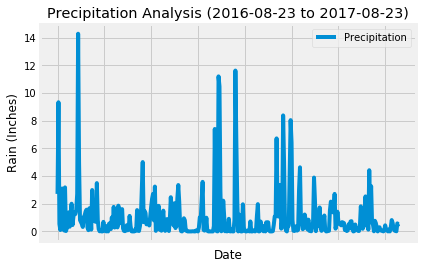

In [12]:
last365 = measdf[pd.to_datetime(measdf.date, format='%Y-%m-%d') >= fdate]
last365 = last365.groupby('date').sum().reset_index()
# plot the dataframe
last365.plot('date', 'prcp')
plt.xlabel("Date")
plt.ylabel("Rain (Inches)")
plt.title(f"Precipitation Analysis (2016-08-23 to {ldate})")
plt.legend(["Precipitation"])
plt.show()

In [14]:
# Use Pandas to calcualte the summary statistics for the precipitation data
last365 = last365.drop(columns='tobs')
last365.describe()

,prcp
count,366.000000
mean,0.978907
std,1.776349
min,0.000000
25%,0.052500
50%,0.405000
75%,1.087500
max,14.280000


In [15]:
# Design a query to show how many stations are available in this dataset?
total.station.nunique()

9

In [17]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
measdf.groupby('station').count().drop(columns='tobs').sort_values(by=['date'], ascending=False).drop(columns=['prcp']).rename(columns={'date': 'Count'})


,Count
station,
USC00519281,2772
USC00519397,2724
USC00513117,2709
USC00519523,2669
USC00516128,2612
USC00514830,2202
USC00511918,1979
USC00517948,1372
USC00518838,511


In [18]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature most active station?
measdf2 = pd.DataFrame(meas)
measdf2.columns = mcol
active = measdf2.station.mode()[0]
mactive = measdf2[measdf2.station == active]
mamt = mactive.tobs.max()
malt = mactive.tobs.min()
maat = mactive.tobs.mean()
print(f'The lowest temperature recorded was {malt}.')
print(f'The highest tempertaure recorded was {mamt}.') 
print(f'The average temperature recorded was {round(maat,2)}.')


The lowest temperature recorded was 54.0.
The highest tempertaure recorded was 85.0.
The average temperature recorded was 71.66.


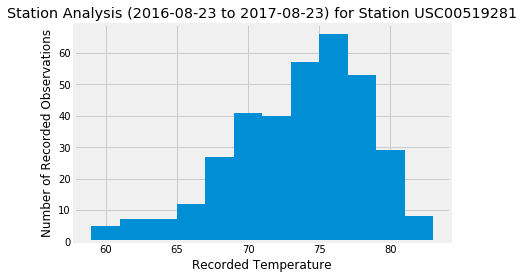

In [21]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
m365 = mactive[pd.to_datetime(mactive.date, format='%Y-%m-%d') >= fdate]
plt.hist(m365['tobs'],12)
plt.xlabel("Recorded Temperature")
plt.ylabel("Number of Recorded Observations")
plt.title(f'Station Analysis (2016-08-23 to {ldate}) for Station {active}')
plt.show()

In [22]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [23]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
print(calc_temps(fdate, ldate))

[(58.0, 74.57894736842105, 87.0)]


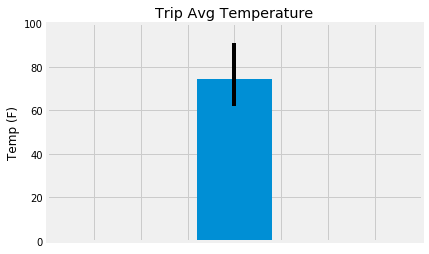

In [25]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
x =1
tripavg = calc_temps(fdate, ldate)

plt.bar(x,tripavg[0][1], yerr=[[tripavg[0][0]-tripavg[0][1]], [tripavg[0][1]-tripavg[0][2]]])
plt.xlim(-1, 3)
plt.ylim(0, 100)
plt.ylabel('Temp (F)')
plt.title('Trip Avg Temperature')
plt.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False) 
plt.show()

In [26]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation
total.groupby('station').agg({'prcp':'sum', 'name': 'first', 'latitude': 'first', 'longitude': 'first', 'elevation': 'first'}).sort_values('prcp', ascending=False)


,prcp,name,latitude,longitude,elevation
station,,,,,
USC00516128,1068.09,"MANOA LYON ARBO 785.2, HI US",21.33310,-157.80250,152.4
USC00519281,588.64,"WAIHEE 837.5, HI US",21.45167,-157.84889,32.9
USC00513117,382.62,"KANEOHE 838.1, HI US",21.42340,-157.80150,14.6
USC00519523,295.68,"WAIMANALO EXPERIMENTAL FARM, HI US",21.33556,-157.71139,19.5
USC00514830,234.49,"KUALOA RANCH HEADQUARTERS 886.9, HI US",21.52130,-157.83740,7.0
USC00519397,131.62,"WAIKIKI 717.2, HI US",21.27160,-157.81680,3.0
USC00511918,92.68,"HONOLULU OBSERVATORY 702.2, HI US",21.31520,-157.99920,0.9
USC00518838,70.87,"UPPER WAHIAWA 874.3, HI US",21.49920,-158.01110,306.6
USC00517948,43.44,"PEARL CITY, HI US",21.39340,-157.97510,11.9


## Optional Challenge Assignment

In [27]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [ ]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


In [ ]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


In [ ]:
# Plot the daily normals as an area plot with `stacked=False`
